# Foundations of Spatial Data Science - CASA0013

## Group Project - Policy Brief

In [1]:
#Importing required packages
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import sklearn.cluster as sklc
import sklearn.metrics as sklm

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib_scalebar.scalebar import ScaleBar
import palettable.colorbrewer.qualitative as pcq
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


In [2]:
#Loading in the LSOA shapefile for spatial visualisation
lsoa = gpd.read_file("data/boundaries/LSOA_2004_London_Low_Resolution.shp")

In [3]:
#Creating a Borough (Local Authoirty) geodataframe from the existing LSOA data
la = lsoa.dissolve(by="LA_NAME")

## Hotels Data

In [4]:
#Reading in the Open Street Map (OSM) data containing pooints of interest across London
osm = gpd.read_file("data/hotel/gis_osm_pois_a_free_1.shp")

In [5]:
#Filtering the OSM data down to only include hotels
hotel = osm[osm["fclass"] == "hotel"]

In [6]:
#LSOA is in the British National Grid (BNG) coordinate reference system.
hotel = hotel.to_crs(lsoa.crs)

In [7]:
#Spatially joining the LSOA to each hotel
lsoa_h = hotel.sjoin(lsoa, predicate="within")

In [8]:
#Number of hotels by LSOA
lsoa_h["count"] = 1
hotel_count = lsoa_h.groupby("LSOA_CODE")["count"].sum().reset_index()

In [9]:
#Merging the number of hotels to the LSOA geodataframe
lsoa_hotels = lsoa.merge(hotel_count, on="LSOA_CODE", how= "left")

In [10]:
#Filling any LSOAs without data to == 0. As any NaNs just mean there were no Hotels present.
lsoa_hotels['count'] = lsoa_hotels['count'].fillna(0)


In [11]:
#Renaming column of count to be relevant to hotels, useful for joining with furhter data also containing counts.
lsoa_hotels = lsoa_hotels.rename(columns={"count": "hotel_count"})

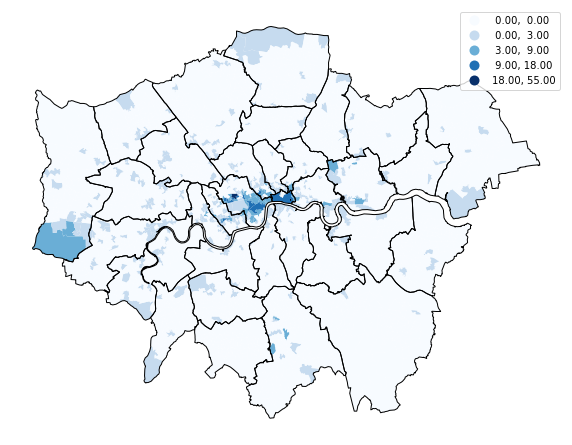

In [12]:
#Visualising the count of hotels (raw value, do not consider in analysis as will be biased by area)
fig, ax = plt.subplots(1, figsize=(10,10))

lsoa_hotels.plot(column = "hotel_count", scheme="fisher_jenks", cmap="Blues", ax=ax, legend=True)
la.plot(color="none", edgecolor="black", linewidth=1, ax=ax)

plt.axis("off")

plt.show()

## AirBnB Data

In [13]:
# Reading in AirBnB listings data
listings = gpd.read_feather("data/2022-09-10-listings.geofeather")

In [14]:
#LSOA is in the British National Grid (BNG) coordinate reference system.
listings = listings.to_crs(lsoa.crs)

In [15]:
#Spatially joining the LSOA to each listing
lsoa_ls = listings.sjoin(lsoa, predicate="within")

In [16]:
#Number of professional vs casual Airbnb hosts by LSOA
lsoa_ls["count"] = 1
airbnb_count = lsoa_ls.groupby("LSOA_CODE")["count"].sum().reset_index()

In [17]:
#Renaming the count column to be specific to AirBnBs to avoid confusion with further joins
airbnb_count = airbnb_count.rename(columns={"count":"airbnb_count"})

In [18]:
#Merging with the larger 'master' dataframe
lsoa_hotels_airbnb = lsoa_hotels.merge(airbnb_count, on="LSOA_CODE", how= "left")

In [19]:
#Filling any NaN values with 0, as it just means there were no AirBnBs present within the LSOA
lsoa_hotels_airbnb['airbnb_count'] = lsoa_hotels_airbnb['airbnb_count'].fillna(0)

## Culture data

In [20]:
#Reading in the cultural dataset from csv
culture = pd.read_csv('data/cultural-infrastructure-map-all-sites.csv')


In [21]:
#Renaming the venue type column for readability
culture = culture.rename(columns = {'Cultural Venue Type':'venue_type'})


In [22]:
#Convert pandas to geopandas
gdf_culture = gpd.GeoDataFrame(culture, geometry=gpd.points_from_xy(culture.longitude, 
                                                                    culture.latitude, 
                                                                    crs='epsg:4326'))

# Reproject to British National Grid (Existing CRS of the LSOA geodataframe)
gdf_culture = gdf_culture.to_crs(lsoa.crs)

In [23]:
#Identifying which cultural points are within each LSOA (spatial join)
lsoa_culture = gdf_culture.sjoin(lsoa, predicate="within")

In [24]:
#Calculating the number of professional vs casual Airbnb hosts by LSOA
lsoa_culture["count"] = 1
culture_count = lsoa_culture.groupby("LSOA_CODE")["count"].sum().reset_index()

In [25]:
#Renaming the count of cultural points within each LSOA to be specific to avoid confusion when merging with 'master' dataframe
culture_count = culture_count.rename(columns={"count":"culture_count"})

In [26]:
#Merging with the 'master' data
lsoa_hotels_airbnb_culture = lsoa_hotels_airbnb.merge(culture_count, on="LSOA_CODE", how= "left")

In [27]:
#Filling in NaN values, as they just equate to LSOAs with no cultural venues. 
lsoa_hotels_airbnb_culture['culture_count'] = lsoa_hotels_airbnb_culture['culture_count'].fillna(0)

## Density for each variable

Density is used to make comparisons across LSOAs possible, as otherwise it is likely that LSOAs with expansive area would bias the results

In [28]:
#Calculating density per km2 for each variable considered
lsoa_hotels_airbnb_culture['culture_density'] = lsoa_hotels_airbnb_culture["culture_count"] / lsoa_hotels_airbnb_culture.area * 1e6
lsoa_hotels_airbnb_culture['hotel_density'] = lsoa_hotels_airbnb_culture["hotel_count"] / lsoa_hotels_airbnb_culture.area * 1e6
lsoa_hotels_airbnb_culture['airbnb_density'] = lsoa_hotels_airbnb_culture["airbnb_count"] / lsoa_hotels_airbnb_culture.area * 1e6

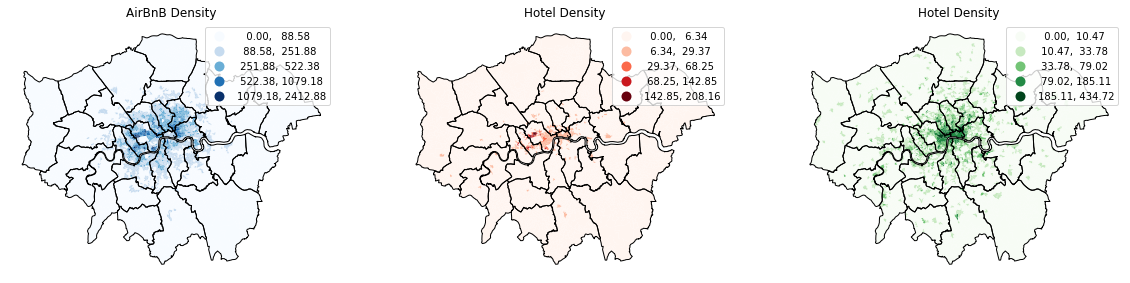

In [29]:
#Map of each considered variable
fig, ax = plt.subplots(1,3, figsize=(20,15))

#AirBnB
lsoa_hotels_airbnb_culture.plot(column = "airbnb_density", scheme="fisher_jenks", cmap="Blues", ax=ax[0], legend=True)
la.plot(color="none", edgecolor="black", linewidth=1, ax=ax[0])

ax[0].axis("off")

ax[0].set_title("AirBnB Density")


#Hotel
lsoa_hotels_airbnb_culture.plot(column = "hotel_density", scheme="fisher_jenks", cmap="Reds", ax=ax[1], legend=True)
la.plot(color="none", edgecolor="black", linewidth=1, ax=ax[1])

ax[1].axis("off")

ax[1].set_title("Hotel Density")



#Culture
lsoa_hotels_airbnb_culture.plot(column = "culture_density", scheme="fisher_jenks", cmap="Greens", ax=ax[2], legend=True)
la.plot(color="none", edgecolor="black", linewidth=1, ax=ax[2])

ax[2].axis("off")

ax[2].set_title("Hotel Density")


plt.savefig("figures/maps_of_variables.png", dpi=300, facecolor="white", bbox_inches="tight")

plt.show()

## Standardisation of data

Standardising the variables between themselves

In [30]:
#Identifying columns of interest
columns = list(lsoa_hotels_airbnb_culture.columns[-3:])

In [31]:
#Applying a MinMaxScaler, allowing easier comparison between variables
mms = MinMaxScaler()
data_standardised = lsoa_hotels_airbnb_culture.copy()
for c in columns:
    data_standardised[c] = mms.fit_transform(lsoa_hotels_airbnb_culture[c].values.reshape(-1,1))

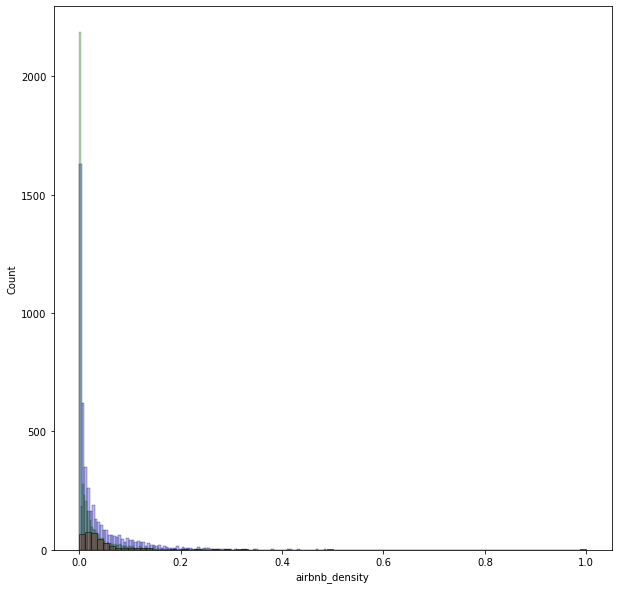

In [32]:
#Plotting the distribution of the standardised variables.
fig, ax = plt.subplots(1, figsize=(10,10))

sns.histplot(data = data_standardised, x="airbnb_density", ax=ax, label="Airbnb", color="b", alpha=0.3)
sns.histplot(data = data_standardised[data_standardised["hotel_density"] > 0], x="hotel_density",  label="Hotel", color="r", alpha=0.3)
sns.histplot(data = data_standardised, x="culture_density", ax=ax, label="Culture", color="g", alpha=0.3)

plt.show()

## Clustering

In [33]:
#Seperating out relevant variable columns
X = data_standardised[columns]

.
.
.
.
.
.
.
.
.
.
.
.
.
.
Largest silhouette score was 0.7809 for k=2


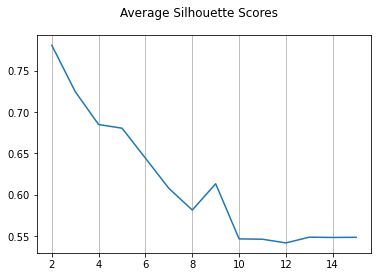

In [34]:
#Visualising an elbow plot, allowing identification of the best 'k'

x = []
y = []
# For resolutions of 'k' in the range 2 to 15
for k in range(2,16):
    #############
    # Do the clustering using the main columns
    kmeans = sklc.KMeans(n_clusters=k, n_init=25, random_state=42).fit(X)
    # Calculate the overall silhouette score
    silhouette_avg = sklm.silhouette_score(X, kmeans.labels_)
    y.append(k)
    x.append(silhouette_avg)
    print('.', end='')
    print()
print(f"Largest silhouette score was {max(x):6.4f} for k={y[x.index(max(x))]}")
plt.plot(y, x)
plt.gca().xaxis.grid(True);
plt.gcf().suptitle("Average Silhouette Scores");

In [35]:
#A random_state is set to allow the kmeans result to be reproducible
random_state_seed = 100
num_clusters = 5 #Identified from the elbow (knee) plot

kmeans_output = sklc.KMeans(n_clusters=num_clusters, random_state=random_state_seed).fit(data_standardised[columns])

#Creating a list of the given clustering labels, ready for joining to the lsoa data
clustering_ids_kmeans = kmeans_output.labels_

In [36]:
#Assigning the cluster id value to the standardised data
data = data_standardised.assign(cluster_id = clustering_ids_kmeans)


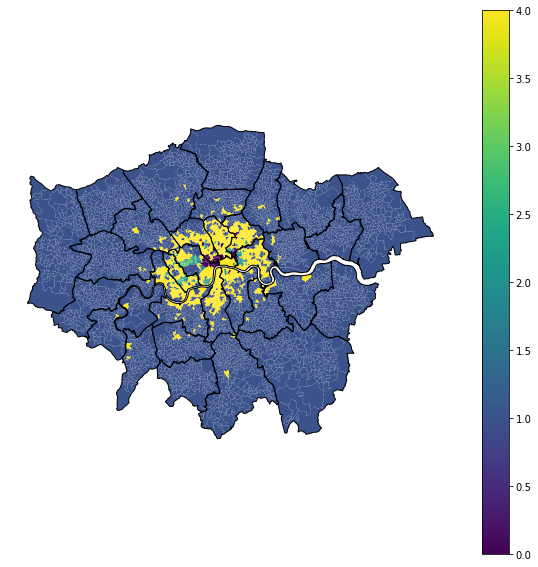

In [37]:
#Mapping the clusters within London
fig, ax = plt.subplots(1, figsize=(10,10))

data.plot(column = "cluster_id", ax=ax, legend=True, k=5)
la.plot(color="none", edgecolor="black", linewidth=1, ax=ax)

plt.axis("off")


plt.savefig("figures/clusters_map4.png", dpi=300, facecolor="white", bbox_inches="tight")
plt.show()

Creating a table of the median, mean and rank table of the values **grouped** by cluster id, in addition to a heatmap. Allowing identification of what each cluster represents

In [38]:
data.groupby("cluster_id")[["hotel_density", "airbnb_density","culture_density"]].median()

,hotel_density,airbnb_density,culture_density
cluster_id,,,
0,0.013251,0.217591,0.386425
1,0.000000,0.007226,0.000000
2,0.034670,0.262918,0.079211
3,0.578134,0.534428,0.081529
4,0.000000,0.104130,0.059524


In [39]:
clusters_data = data.groupby("cluster_id")[["hotel_density", "airbnb_density","culture_density"]].mean()
clusters_data

,hotel_density,airbnb_density,culture_density
cluster_id,,,
0,0.037369,0.253694,0.442512
1,0.001034,0.014831,0.009137
2,0.071991,0.312300,0.093400
3,0.636146,0.546865,0.072227
4,0.006166,0.108758,0.070689


<AxesSubplot:ylabel='cluster_id'>

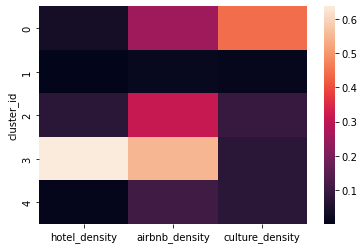

In [40]:
sns.heatmap(clusters_data)

In [41]:
clusters_data.rank()

,hotel_density,airbnb_density,culture_density
cluster_id,,,
0,3.0,3.0,5.0
1,1.0,1.0,1.0
2,4.0,4.0,4.0
3,5.0,5.0,3.0
4,2.0,2.0,2.0


Table for 5 clusters




|  Cluster ID| Description (Hotel, AirBnB, Culture) |
| --- | --- | 
| 0 |Mid - Mid -High |
| 1 | Low - Low - Low |
| 2 | Mid - high - Mid|
| 3 | High - High - Mid |
| 4 | Low - Mid - Mid|

In [42]:
#Identifying the silhouette score for the clustering model put to use
silhouette_kmeans = sklm.silhouette_score(data_standardised[columns],clustering_ids_kmeans)


print("Silhouette Score:", silhouette_kmeans)


Silhouette Score: 0.6696018553779441


### Mapping Clustering IDs

In [43]:
#Identifying the extent of the study area
tbounds = list(la.total_bounds)

In [44]:
#Identifying how much around the edge of each figure should be added
extra_bound = 0.1
x1, y1 = 2500, 2500

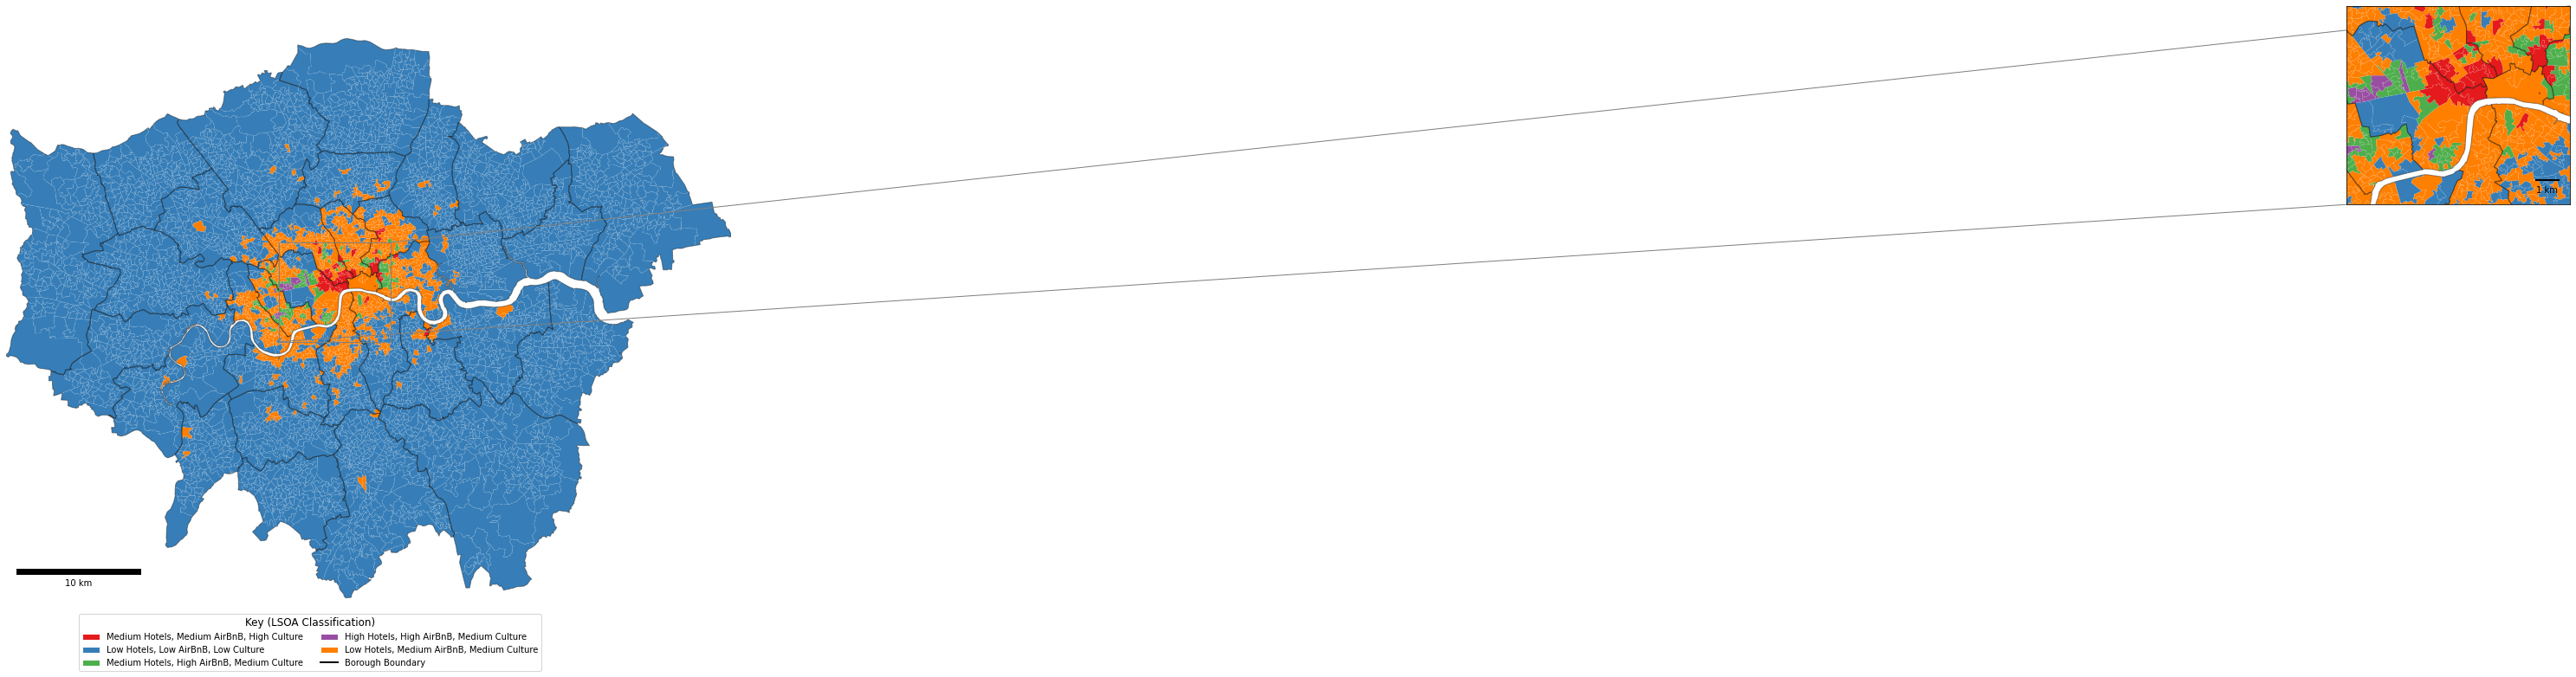

In [45]:
#Inisalising the plots with specific size (inches)
fig, ax = plt.subplots(figsize=(15, 20))

#Main plot
data.plot(column = "cluster_id", ax=ax, legend=True, k=5,
             scheme="fisher_jenks", edgecolor="white", linewidth=0.05,
            cmap = pcq.Set1_5.mpl_colormap)

la.plot(ax=ax, color="none", edgecolor="black", linewidth=1, alpha=0.4)

#Setting main plot x and y limits
plt.xlim(tbounds[0]-extra_bound , tbounds[2] +extra_bound)
plt.ylim(tbounds[1] -extra_bound, tbounds[3]+extra_bound)

ax.add_artist(ScaleBar(1, box_color='none', location="lower left", border_pad=1))

legend_e = [Patch(facecolor= "#e41a1c", edgecolor="white", label="Medium Hotels, Medium AirBnB, High Culture"),
            Patch(facecolor= "#377eb8", edgecolor="white", label="Low Hotels, Low AirBnB, Low Culture"),
            Patch(facecolor= "#4daf4a", edgecolor="white", label="Medium Hotels, High AirBnB, Medium Culture"),
            Patch(facecolor= "#984ea3", edgecolor="white", label="High Hotels, High AirBnB, Medium Culture"),
            Patch(facecolor= "#ff7f00", edgecolor="white", label="Low Hotels, Medium AirBnB, Medium Culture"),
            Line2D([0], [0], color="black", lw=2, linestyle="-", label="Borough Boundary")]

plt.legend(handles=legend_e, loc= (0.10, -0.13), title="Key (LSOA Classification)", title_fontsize="large", ncol=2)





#Starting the zoomed axis
axins = zoomed_inset_axes(ax, 2, loc=4, bbox_to_anchor=(3100, 850))

#Establishing the x and y limits for the zoomed plot
minx,miny,maxx,maxy =  528000, 179000, 532000, 182000
axins.set_xlim(minx - x1, maxx + x1)
axins.set_ylim(miny - y1, maxy + y1)

#Setting the box on the main plot to then zoom to the zoomed plot
mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")

#Scale bar for zoom plot
axins.add_artist(ScaleBar(1, box_color='none', location="lower right", border_pad=1))

# Plot zoom window
data.plot(column = "cluster_id", ax=axins, legend=False, k=5,
             scheme="fisher_jenks", edgecolor="white", linewidth=0.05,
            cmap = pcq.Set1_5.mpl_colormap)

la.plot(ax=axins, color="none", edgecolor="black", linewidth=1, alpha=0.4)


plt.setp(axins.get_xticklabels(), visible=False)
plt.setp(axins.get_yticklabels(), visible=False)

ax.set_axis_off()
axins.set_yticks([])
axins.set_xticks([])

plt.savefig("figures/5cluster_map(with inset).png", dpi=200, facecolor="white", bbox_inches="tight")


plt.show()